In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import SequentialPerception, build_network
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def sequential_trial(dP, ramp=0.1, threshold=0.4, relative=1, perception_seed=0, network_seed=0,
                 dt=0.001, cues_max=18, dt_sample=0.5, rA=2.0, nNeurons=1000, legend=False, name="sequential"):

    inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
    inputs.create(dP=dP)
    net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > 0.01):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > 2*cues_max*dt_sample:
            choice = np.argmax(sim.data[net.pValue][-1,:])
            RT = sim.trange()[-1]
    correct = 1 if choice==net.inputs.correct else 0

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    for a in range(2):
        axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], label=f"Evidence {a}") 
    for a in range(2):
        axes[0].plot(sim.trange(), np.cumsum(sim.data[net.pInputs][:,a]*dt*ramp), color=palette[a], label=f"True {a}", linestyle="--") 
        axes[1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {a}") 
    axes[1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label='Threshold', color="red", linestyle=":")
    axes[0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Evidence in Accumulator")
    axes[1].set(xlabel="Time (s)", title="Decision Criteria")
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='upper left')
        leg.get_texts()[net.inputs.correct].set_color("lime" if correct else "red")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

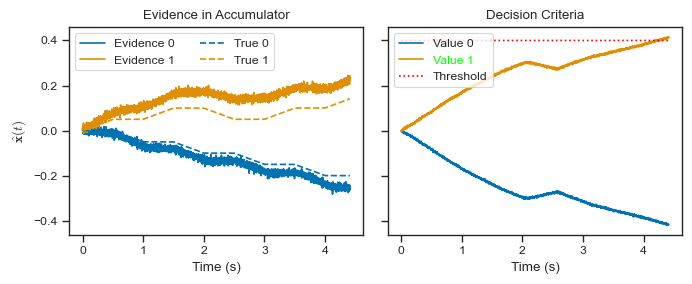

In [50]:
sequential_trial(dP=0.4, ramp=0.1, threshold=0.4, legend=True)

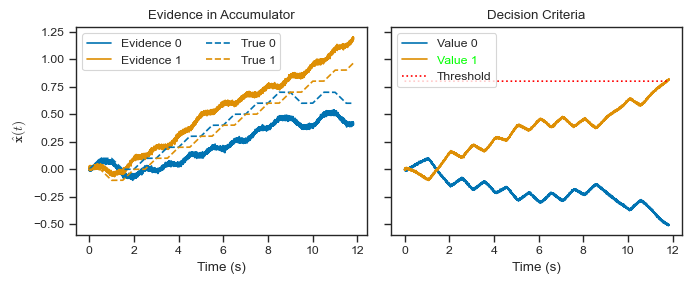

In [51]:
sequential_trial(dP=0.1, ramp=0.2, threshold=0.8, relative=0.8, perception_seed=3, legend=True)

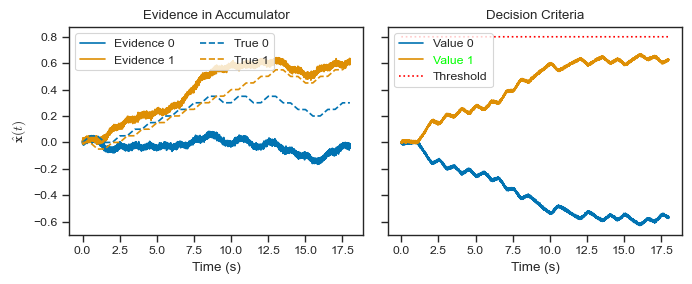

In [54]:
sequential_trial(dP=0.1, ramp=0.1, threshold=0.8, relative=0.9, perception_seed=3, legend=True)

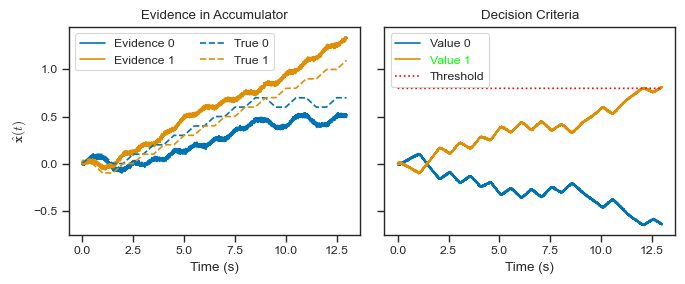

In [55]:
sequential_trial(dP=0.1, ramp=0.2, threshold=0.8, relative=0.9, perception_seed=3, legend=True)

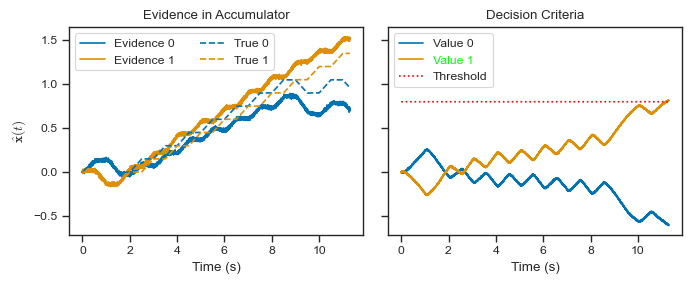

In [56]:
sequential_trial(dP=0.1, ramp=0.3, threshold=0.8, relative=0.9, perception_seed=3, legend=True)

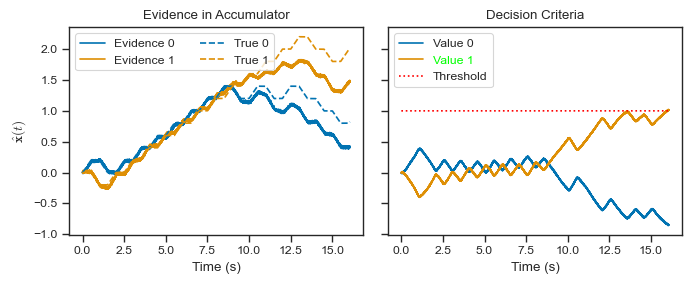

In [57]:
sequential_trial(dP=0.1, ramp=0.4, threshold=1.0, relative=0.9, perception_seed=3, legend=True)

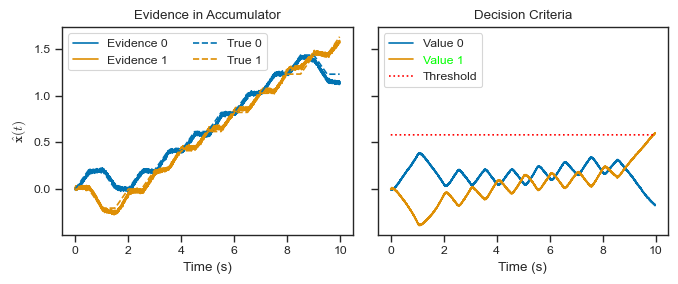

In [97]:
sequential_trial(dP=0.1, ramp=0.41, relative=0.84, threshold=0.58, perception_seed=3, legend=True)

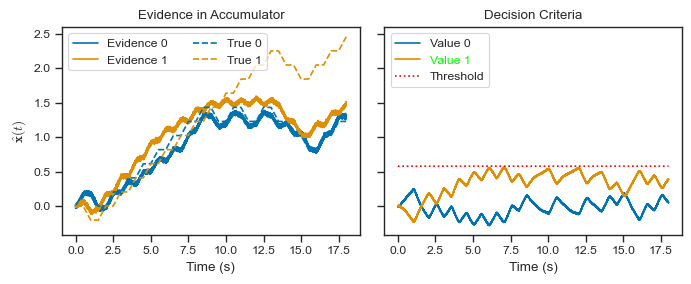

In [98]:
sequential_trial(dP=0.1, ramp=0.41, relative=0.84, threshold=0.58, perception_seed=3, nNeurons=500, legend=True)

In [3]:
def sequential_agent(dP, ramp=0.1, threshold=0.4, relative=1, perception_seed=0, network_seed=0,
                 experiment_time=60.0, dt=0.001, cues_max=18, dt_sample=0.5, name="sequential_agent"):

    inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
    dfs = []
    columns = ('agent', 'trial', 'accuracy', 'RT')
    total_time = 0
    trial = 0
    while total_time < experiment_time:
        print(f"trial {trial}")
        inputs.create(dP=dP)
        net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > cues_max*dt_sample:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
        correct = 1 if choice==net.inputs.correct else 0
        dfs.append(pd.DataFrame([['test agent', trial, 100*correct, RT]], columns=columns))
        total_time += RT
        trial += 1

    data = pd.concat(dfs, ignore_index=True)
    print(f"{trial} trials completed in {experiment_time} seconds; mean accuracy {data['accuracy'].mean()}")

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((3.5, 3)))
    sns.histplot(data=data, x="RT", stat="percent", palette=palette[0], ax=ax)
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

In [4]:
# sequential_agent(dP=0.4, ramp=0.3, threshold=0.8, experiment_time=120.0)

In [5]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_loss(simulated, empirical, max_cues, cue_step):
    bins = np.arange(0.0, 2*max_cues+cue_step, cue_step)
    cues_sim = simulated['cues'].to_numpy()
    cues_emp = empirical['cues'].to_numpy()
    hist_cues_sim = np.histogram(cues_sim, bins=bins)[0]
    hist_cues_emp = np.histogram(cues_emp, bins=bins)[0]
    normed_hist_cues_sim = hist_cues_sim / len(cues_sim)
    normed_hist_cues_emp = hist_cues_emp / len(cues_emp)
    loss = chi_squared_distance(normed_hist_cues_sim, normed_hist_cues_emp)
    print(f"loss {loss}")
    return loss

def compare_accuracy(simfile, max_cues, pid):
    pidstr = str(pid)
    emp = pd.read_pickle("data/fiedler2021.pkl").query(f"max_cues==@max_cues & id==@pidstr")
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    for dP in [0.4, 0.2, 0.1]:
        emp_mean = emp.query("dP==@dP")['accuracy'].mean()
        sim_mean = sim.query("dP==@dP")['accuracy'].mean()
        print(f"dP {dP}, emp mean {emp_mean}, sim_mean {sim_mean}")

In [6]:
def scan_dP(dPs=[0.4, 0.2, 0.1], ramp=0.1, threshold=0.4, relative=1, perception_seed=0, pid=0,
                 rA=2.0, nNeurons=1000, experiment_time=60.0, dt=0.001, max_cues=12, cue_step=4, dt_sample=0.5, name="scan_dP", load=False):

    if not load:
        dfs = []
        columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues', 'max_cues')
        for dP in dPs:
            inputs = SequentialPerception(seed=int(dP*10), dt_sample=dt_sample)
            inputs.create(dP=dP)
            total_time = 0
            trial = 0
            while total_time < experiment_time:
                # net = build_network(inputs, seed=pid, ramp=ramp, threshold=threshold, nNeurons=nNeurons, relative=relative)
                net = build_network(inputs, seed=trial, ramp=ramp, threshold=threshold, nNeurons=nNeurons, relative=relative, rA=rA)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                RT = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > 2*max_cues*dt_sample:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = 1 if choice==net.inputs.correct else 0
                cues = int(RT/dt_sample)+1
                print(f"trial {trial}, dP {dP}, elapsed time {total_time}, cues {cues}")
                dfs.append(pd.DataFrame([['model', id, dP, trial, 100*correct, cues, max_cues]], columns=columns))
                total_time += RT
                trial += 1
        # print(f"{trial} trials completed in {experiment_time} seconds; mean accuracy {data['accuracy'].mean()}")
        sim = pd.concat(dfs, ignore_index=True)
        sim.to_pickle(f"data/{name}_{pid}.pkl")
    else:
        sim = pd.read_pickle(f"data/{name}_{pid}.pkl")

    pidstr = str(pid)
    emp = pd.read_pickle("data/fiedler2021.pkl").query(f"max_cues==@max_cues & id==@pidstr")
    data = pd.concat([sim, emp], ignore_index=True)
    for dP in dPs:
        loss = get_loss(data.query("type=='model' & dP==@dP"), data.query("type=='human' & dP==@dP"), max_cues, cue_step)
        print(f"dP {dP}, loss {loss}")

    fig = sns.FacetGrid(data, col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=1.5, aspect=1.5)  # row="type",
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", hue='type', palette=palette[:2],
                      bins=np.arange(0, 2*max_cues+cue_step, cue_step), common_norm=False)
    fig.set_xlabels("Cues Sampled Per Trial")
    fig.add_legend()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

loss 0.03671747544335656
dP 0.4, loss 0.03671747544335656
loss 0.16216171306832539
dP 0.2, loss 0.16216171306832539
loss 0.15283117839203317
dP 0.1, loss 0.15283117839203317


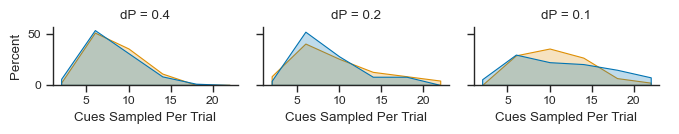

In [113]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*5, ramp=0.38, relative=0.83, threshold=0.48, pid=2, max_cues=12, name="pid2_short", load=True)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, dP 0.4, elapsed time 0, cues 4
trial 1, dP 0.4, elapsed time 1.51, cues 6
trial 2, dP 0.4, elapsed time 4.285, cues 19
trial 3, dP 0.4, elapsed time 13.765, cues 8
trial 4, dP 0.4, elapsed time 17.66, cues 4
trial 5, dP 0.4, elapsed time 19.315, cues 4
trial 6, dP 0.4, elapsed time 21.097, cues 4
trial 7, dP 0.4, elapsed time 22.788, cues 4
trial 8, dP 0.4, elapsed time 24.319, cues 4
trial 9, dP 0.4, elapsed time 26.256, cues 4
trial 10, dP 0.4, elapsed time 27.924, cues 5
trial 11, dP 0.4, elapsed time 30.064999999999998, cues 4
trial 12, dP 0.4, elapsed time 31.688999999999997, cues 3
trial 13, dP 0.4, elapsed time 33.025, cues 6
trial 14, dP 0.4, elapsed time 35.789, cues 11
trial 15, dP 0.4, elapsed time 40.883, cues 15
trial 16, dP 0.4, elapsed time 48.185, cues 7
trial 17, dP 0.4, elapsed time 51.349000000000004, cues 8
trial 18, dP 0.4, elapsed time 55.292, cues 25
trial 19, dP 0.4, elapsed time 67.293, cues 4
trial 20, dP 0.4, elapsed time 69.003, cues 9
trial 21, dP 

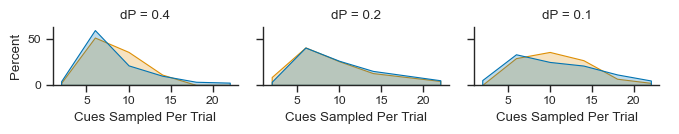

In [15]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*20, ramp=0.38, relative=0.83, threshold=0.48, pid=2, max_cues=12, name="pid2_long", load=False)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, dP 0.4, elapsed time 0, cues 9
trial 1, dP 0.4, elapsed time 4.47, cues 25
trial 2, dP 0.4, elapsed time 16.471, cues 8
trial 3, dP 0.4, elapsed time 20.326, cues 9
trial 4, dP 0.4, elapsed time 24.686, cues 8
trial 5, dP 0.4, elapsed time 28.465, cues 8
trial 6, dP 0.4, elapsed time 32.459, cues 20
trial 7, dP 0.4, elapsed time 42.34, cues 15
trial 8, dP 0.4, elapsed time 49.579, cues 25
trial 9, dP 0.4, elapsed time 61.58, cues 25
trial 10, dP 0.4, elapsed time 73.581, cues 25
trial 11, dP 0.4, elapsed time 85.58200000000001, cues 17
trial 12, dP 0.4, elapsed time 93.98700000000001, cues 21
trial 13, dP 0.4, elapsed time 104.108, cues 14
trial 14, dP 0.4, elapsed time 110.852, cues 25
trial 15, dP 0.4, elapsed time 122.85300000000001, cues 16
trial 16, dP 0.4, elapsed time 130.58100000000002, cues 16
trial 17, dP 0.4, elapsed time 138.20600000000002, cues 16
trial 18, dP 0.4, elapsed time 145.735, cues 19
trial 19, dP 0.4, elapsed time 155.12800000000001, cues 15
trial 20, d

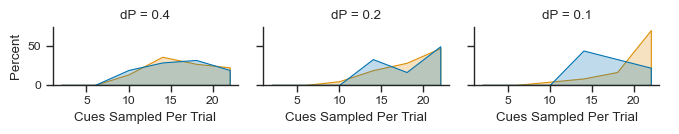

In [8]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*5, ramp=0.29, relative=0.81, threshold=0.85, pid=44, max_cues=12, name='nov23a', load=False)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, dP 0.4, elapsed time 0, cues 9
trial 1, dP 0.4, elapsed time 4.47, cues 25
trial 2, dP 0.4, elapsed time 16.471, cues 8
trial 3, dP 0.4, elapsed time 20.326, cues 9
trial 4, dP 0.4, elapsed time 24.686, cues 8
trial 5, dP 0.4, elapsed time 28.465, cues 8
trial 6, dP 0.4, elapsed time 32.459, cues 20
trial 7, dP 0.4, elapsed time 42.34, cues 15
trial 8, dP 0.4, elapsed time 49.579, cues 25
trial 9, dP 0.4, elapsed time 61.58, cues 25
trial 10, dP 0.4, elapsed time 73.581, cues 25
trial 11, dP 0.4, elapsed time 85.58200000000001, cues 17
trial 12, dP 0.4, elapsed time 93.98700000000001, cues 21
trial 13, dP 0.4, elapsed time 104.108, cues 14
trial 14, dP 0.4, elapsed time 110.852, cues 25
trial 15, dP 0.4, elapsed time 122.85300000000001, cues 16
trial 16, dP 0.4, elapsed time 130.58100000000002, cues 16
trial 17, dP 0.4, elapsed time 138.20600000000002, cues 16
trial 18, dP 0.4, elapsed time 145.735, cues 19
trial 19, dP 0.4, elapsed time 155.12800000000001, cues 15
trial 20, d

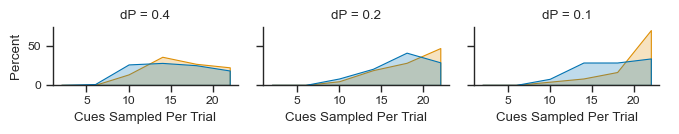

In [16]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*20, ramp=0.29, relative=0.81, threshold=0.85, pid=44, max_cues=12, name='pid44_long', load=False)

In [109]:
compare_accuracy("scan_DP_2", max_cues=12, pid=2)

dP 0.4, emp mean 93.33333333333333, sim_mean 98.83720930232558
dP 0.2, emp mean 93.61702127659575, sim_mean 90.69767441860465
dP 0.1, emp mean 73.33333333333333, sim_mean 66.66666666666667


In [11]:
compare_accuracy("nov23a_44", max_cues=12, pid=44)

dP 0.4, emp mean 100.0, sim_mean 97.29729729729729
dP 0.2, emp mean 95.23809523809524, sim_mean 77.77777777777777
dP 0.1, emp mean 95.83333333333333, sim_mean 75.0


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, dP 0.4, elapsed time 0, cues 10
trial 1, dP 0.4, elapsed time 4.546, cues 25
trial 2, dP 0.4, elapsed time 16.547, cues 8
trial 3, dP 0.4, elapsed time 20.394000000000002, cues 9
trial 4, dP 0.4, elapsed time 24.709000000000003, cues 8
trial 5, dP 0.4, elapsed time 28.660000000000004, cues 11
trial 6, dP 0.4, elapsed time 33.965, cues 25
trial 7, dP 0.4, elapsed time 45.966, cues 12
trial 8, dP 0.4, elapsed time 51.537, cues 25
trial 9, dP 0.4, elapsed time 63.538, cues 25
trial 10, dP 0.4, elapsed time 75.539, cues 25
trial 11, dP 0.4, elapsed time 87.54, cues 13
trial 12, dP 0.4, elapsed time 93.876, cues 19
trial 13, dP 0.4, elapsed time 103.364, cues 14
trial 14, dP 0.4, elapsed time 110.034, cues 25
trial 15, dP 0.4, elapsed time 122.03500000000001, cues 16
trial 16, dP 0.4, elapsed time 129.673, cues 13
trial 17, dP 0.4, elapsed time 135.827, cues 16
trial 18, dP 0.4, elapsed time 143.521, cues 18
trial 19, dP 0.4, elapsed time 152.09699999999998, cues 18
trial 20, dP 0.

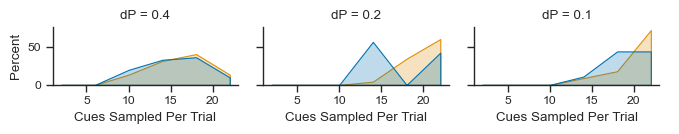

In [14]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*5, ramp=0.31, relative=0.81, threshold=0.92, pid=9, max_cues=12, name='nov24a', load=False)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, dP 0.4, elapsed time 0, cues 10
trial 1, dP 0.4, elapsed time 4.546, cues 25
trial 2, dP 0.4, elapsed time 16.547, cues 8
trial 3, dP 0.4, elapsed time 20.394000000000002, cues 9
trial 4, dP 0.4, elapsed time 24.709000000000003, cues 8
trial 5, dP 0.4, elapsed time 28.660000000000004, cues 11
trial 6, dP 0.4, elapsed time 33.965, cues 25
trial 7, dP 0.4, elapsed time 45.966, cues 12
trial 8, dP 0.4, elapsed time 51.537, cues 25
trial 9, dP 0.4, elapsed time 63.538, cues 25
trial 10, dP 0.4, elapsed time 75.539, cues 25
trial 11, dP 0.4, elapsed time 87.54, cues 13
trial 12, dP 0.4, elapsed time 93.876, cues 19
trial 13, dP 0.4, elapsed time 103.364, cues 14
trial 14, dP 0.4, elapsed time 110.034, cues 25
trial 15, dP 0.4, elapsed time 122.03500000000001, cues 16
trial 16, dP 0.4, elapsed time 129.673, cues 13
trial 17, dP 0.4, elapsed time 135.827, cues 16
trial 18, dP 0.4, elapsed time 143.521, cues 18
trial 19, dP 0.4, elapsed time 152.09699999999998, cues 18
trial 20, dP 0.

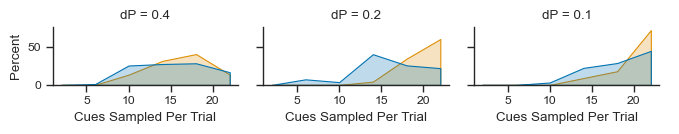

In [17]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*20, ramp=0.31, relative=0.81, threshold=0.92, pid=9, max_cues=12, name='pid9_long', load=False)

In [40]:
def remake_fiedler():
    emp = pd.read_pickle("data/empirical.pkl")
    dfs = []
    columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues', 'max_cues')
    for i, pid in enumerate(emp['participant_id'].unique()):
        for dP in [0.4, 0.2, 0.1]:
            # print(f"pid {pid}, dP {dP}")
            subdata = emp.query("participant_id==@pid & delta==@dP")
            trial = 0
            for index, row in subdata.iterrows():
                dfs.append(pd.DataFrame([["human", f"{i}", dP, trial, 100*row['correct'], row['cues'], row['maxSamples']]], columns=columns))
                trial += 1
    df = pd.concat(dfs, ignore_index=True)
    df.to_pickle("data/fiedler2021.pkl")

In [41]:
remake_fiedler()

In [19]:
def condense_fiedler():
    dfs = []
    columns = ('type', 'id', 'dP', 'mean cues', 'var cues', 'mean acc', 'var acc')
    emp = pd.read_pickle("data/fiedler2021.pkl")
    for pid in emp['id'].unique():
        for dP in [0.4, 0.2, 0.1]:
            subdata = emp.query("id==@pid & dP==@dP")
            mean_cues = subdata['cues'].mean()
            var_cues = subdata['cues'].std()
            mean_acc = subdata['accuracy'].mean()
            var_acc = subdata['accuracy'].std()
            dfs.append(pd.DataFrame([['human', pid, dP, mean_cues, var_cues, mean_acc, var_acc]], columns=columns))
    new_emp = pd.concat(dfs, ignore_index=True)
    new_emp.to_pickle("data/fiedler2021_condensed.pkl")

In [20]:
def plot_condensed():
    new_emp = read_pickle("data/fiedler2021_condensed.pkl")
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=((7,2)))
    for i, dP in enumerate([0.4, 0.2, 0.1]):
        subdata = new_emp.query("dP==@dP")
        x = subdata['mean cues'].to_numpy()
        y = subdata['mean acc'].to_numpy()
        xerr = subdata['var cues'].to_numpy()
        yerr = subdata['var acc'].to_numpy()
        axes[i].errorbar(x, y, xerr=xerr, yerr=0*yerr, fmt="o")
    plt.tight_layout()

    fig = sns.FacetGrid(new_emp, row="type", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1)
    fig.map_dataframe(sns.scatterplot, x="mean cues", y="mean acc")
    fig.set_xlabels("Mean Cues")
    fig.set_ylabels("Mean Accuracy")
    fig.set(yticks=[50, 60, 70, 80, 90, 100])
    fig.add_legend()
    fig.savefig(f"plots/facet2.svg")
    fig.savefig(f"plots/facet2.png", dpi=600)

In [21]:
def plot_emp_RTs(max_cues, cue_step):
    emp = pd.read_pickle("data/fiedler2021.pkl").query("max_cues==@max_cues")
    fig = sns.FacetGrid(emp, row="id", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=1.5, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=np.arange(0, 2*max_cues+cue_step, cue_step), common_norm=False)
    fig.set_xlabels("Cues Sampled Per Trial")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_all_RTs_{max_cues}.svg")
    fig.savefig(f"plots/fiedler_all_RTs_{max_cues}.png", dpi=600)

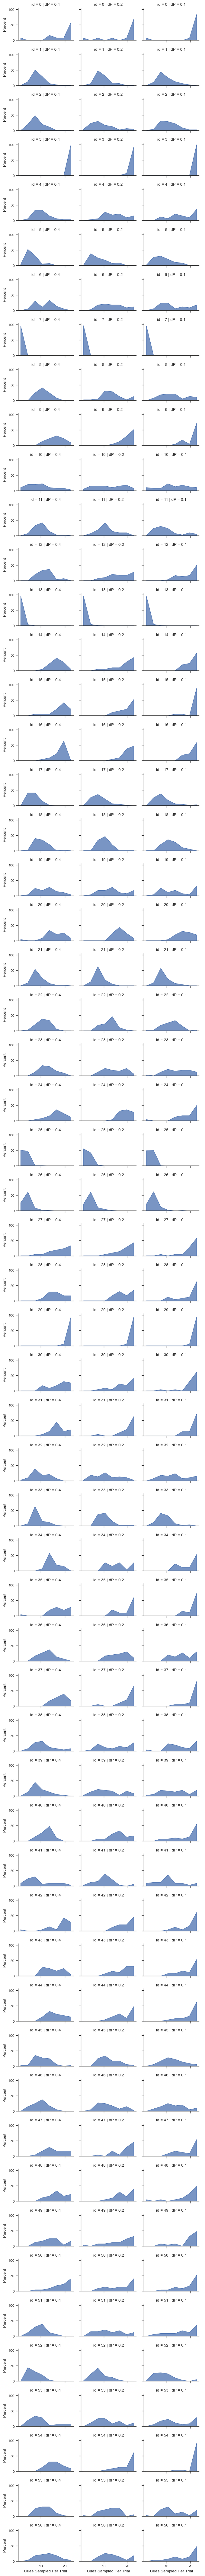

In [22]:
plot_emp_RTs(max_cues=12, cue_step=3)

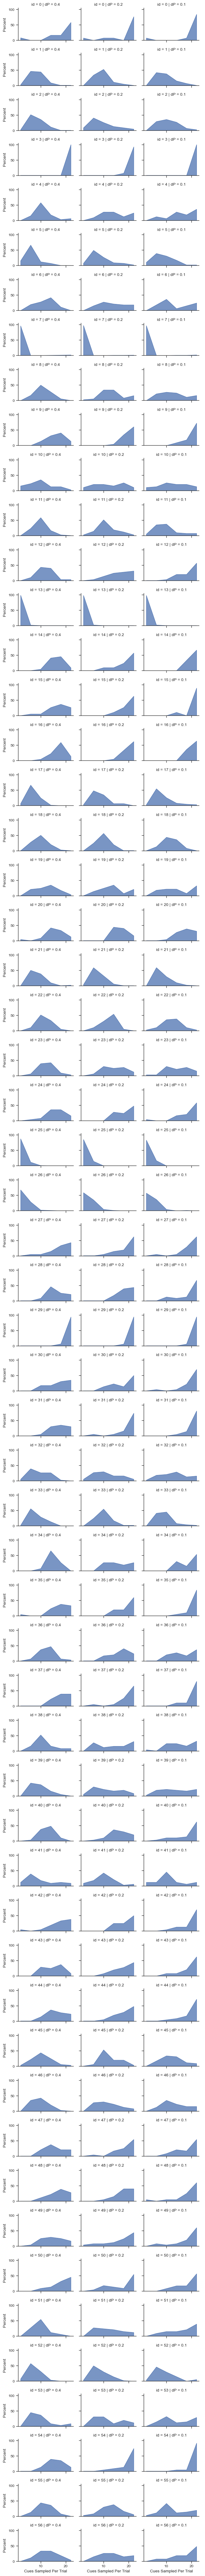

In [11]:
plot_emp_RTs(max_cues=12, cue_step=4)

In [120]:
def agent_population(nAgents, dPs=[0.4, 0.2, 0.1], ramps=[0.2, 0.4], thresholds=[0.8, 1.0], relative=1, perception_seed=0, network_seed=0,
                 experiment_time=60.0, dt=0.001, cues_max=18, dt_sample=0.5, name="agent_population", load=False):

    rng = np.random.RandomState(seed=perception_seed)
    if not load:
        dfs = []
        for agent in range(nAgents):
            ramp = rng.uniform(ramps[0], ramps[1])
            threshold = rng.uniform(thresholds[0], thresholds[1])
            inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
            columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues')
            for dP in dPs:
                inputs.create(dP=dP)
                total_time = 0
                trial = 0
                while total_time < experiment_time:
                    print(f"trial {trial}, dP {dP}, agent {agent}")
                    net = build_network(inputs, seed=agent, ramp=ramp, threshold=threshold, relative=relative)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    RT = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > cues_max*dt_sample:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = 1 if choice==net.inputs.correct else 0
                    cues = int(RT/dt_sample)+1
                    dfs.append(pd.DataFrame([['model', agent, dP, trial, 100*correct, cues]], columns=columns))
                    total_time += RT
                    trial += 1
        sim = pd.concat(dfs, ignore_index=True)
        sim.to_pickle("data/agent_population.pkl")
    else:
        sim = pd.read_pickle("data/agent_population.pkl")

    dfs = []
    columns = ('type', 'id', 'dP', 'mean cues', 'var cues', 'mean acc', 'var acc')
    emp = pd.read_pickle("data/fiedler2021_new.pkl")
    combined = pd.concat([sim, emp], ignore_index=True)    
    for type in ['model', 'human']:
        for pid in combined.query("type==@type")['id'].unique():
            for dP in [0.4, 0.2, 0.1]:
                subdata = combined.query("id==@pid & dP==@dP")
                mean_cues = subdata['cues'].mean()
                var_cues = subdata['cues'].std()
                mean_acc = subdata['accuracy'].mean()
                var_acc = subdata['accuracy'].std()
                dfs.append(pd.DataFrame([[type, pid, dP, mean_cues, var_cues, mean_acc, var_acc]], columns=columns))
    new_combined = pd.concat(dfs, ignore_index=True)
    new_combined.to_pickle("data/population_combined.pkl")

    fig = sns.FacetGrid(new_combined, row="type", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1)
    fig.map_dataframe(sns.scatterplot, x="mean cues", y="mean acc")
    fig.set_xlabels("Mean Cues")
    fig.set_ylabels("Mean Accuracy")
    fig.set(yticks=[50, 60, 70, 80, 90, 100])
    fig.add_legend()
    fig.savefig(f"plots/population_combined.svg")
    fig.savefig(f"plots/population_combined.png", dpi=600)

trial 0, dP 0.4, agent 0
trial 1, dP 0.4, agent 0
trial 2, dP 0.4, agent 0
trial 3, dP 0.4, agent 0
trial 4, dP 0.4, agent 0
trial 5, dP 0.4, agent 0
trial 6, dP 0.4, agent 0
trial 7, dP 0.4, agent 0
trial 8, dP 0.4, agent 0
trial 9, dP 0.4, agent 0
trial 10, dP 0.4, agent 0
trial 11, dP 0.4, agent 0
trial 12, dP 0.4, agent 0
trial 13, dP 0.4, agent 0
trial 14, dP 0.4, agent 0
trial 15, dP 0.4, agent 0
trial 16, dP 0.4, agent 0
trial 17, dP 0.4, agent 0
trial 18, dP 0.4, agent 0
trial 19, dP 0.4, agent 0
trial 0, dP 0.2, agent 0
trial 1, dP 0.2, agent 0
trial 2, dP 0.2, agent 0
trial 3, dP 0.2, agent 0
trial 4, dP 0.2, agent 0
trial 5, dP 0.2, agent 0
trial 6, dP 0.2, agent 0
trial 7, dP 0.2, agent 0
trial 8, dP 0.2, agent 0
trial 9, dP 0.2, agent 0
trial 10, dP 0.2, agent 0
trial 11, dP 0.2, agent 0
trial 12, dP 0.2, agent 0
trial 13, dP 0.2, agent 0
trial 14, dP 0.2, agent 0
trial 15, dP 0.2, agent 0
trial 0, dP 0.1, agent 0
trial 1, dP 0.1, agent 0
trial 2, dP 0.1, agent 0
trial 3, 

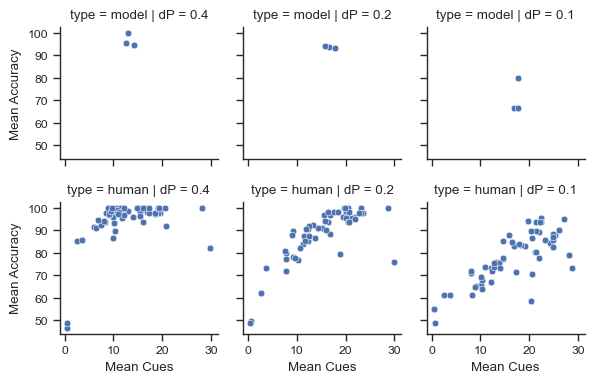

In [121]:
agent_population(nAgents=3, experiment_time=120, load=False)

trial 0, dP 0.4, agent 0
trial 1, dP 0.4, agent 0
trial 2, dP 0.4, agent 0
trial 3, dP 0.4, agent 0
trial 4, dP 0.4, agent 0
trial 5, dP 0.4, agent 0
trial 6, dP 0.4, agent 0
trial 7, dP 0.4, agent 0
trial 8, dP 0.4, agent 0
trial 9, dP 0.4, agent 0
trial 10, dP 0.4, agent 0
trial 11, dP 0.4, agent 0
trial 12, dP 0.4, agent 0
trial 13, dP 0.4, agent 0
trial 14, dP 0.4, agent 0
trial 15, dP 0.4, agent 0
trial 16, dP 0.4, agent 0
trial 17, dP 0.4, agent 0
trial 0, dP 0.2, agent 0
trial 1, dP 0.2, agent 0
trial 2, dP 0.2, agent 0
trial 3, dP 0.2, agent 0
trial 4, dP 0.2, agent 0
trial 5, dP 0.2, agent 0
trial 6, dP 0.2, agent 0
trial 7, dP 0.2, agent 0
trial 8, dP 0.2, agent 0
trial 9, dP 0.2, agent 0
trial 10, dP 0.2, agent 0
trial 11, dP 0.2, agent 0
trial 12, dP 0.2, agent 0
trial 13, dP 0.2, agent 0
trial 0, dP 0.1, agent 0
trial 1, dP 0.1, agent 0
trial 2, dP 0.1, agent 0
trial 3, dP 0.1, agent 0
trial 4, dP 0.1, agent 0
trial 5, dP 0.1, agent 0
trial 6, dP 0.1, agent 0
trial 7, dP 0

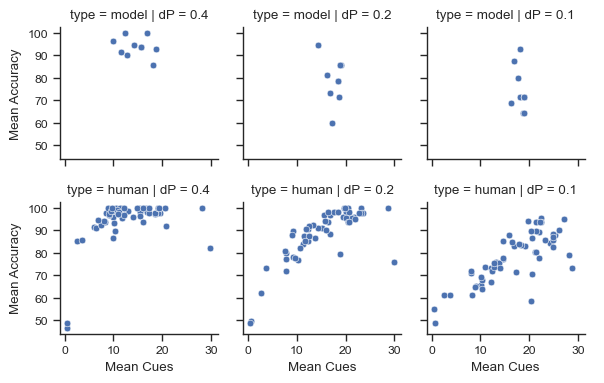

In [123]:
agent_population(nAgents=10, experiment_time=120, load=False, thresholds=[0.6, 1.2], ramps=[0.2, 0.4])